In [1]:
import sys
import os
import re
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
import seaborn as sns
from scipy.stats import kurtosis

sns.set()
pth_current = Path.cwd()

os.chdir(pth_current.parent)
sys.path.append(pth_current.parent)

In [2]:
def find_method(name):
    if "autoencoder" in name:
        encoding_method_str = re.sub(r"-autoencoder(-\d*)?", "", name)
        return (encoding_method_str, 0)

    elif "johnson-lindenstarauss" in name:
        encoding_method_str = re.sub(r"-johnson-lindenstarauss(-\d*)?", "", name)
        return (encoding_method_str, 1)

    elif "no-reduction" in name:
        encoding_method_str = re.sub(r"-no-reduction(-\d*)?", "", name)
        return (encoding_method_str, 2)

    return None

pos_to_method_mapping = ["autoencoder", "johnson-lindenstarauss", "no-reduction"]

In [3]:
dct_method_true_positives = {}
dct_method_true_negatives = {}
dct_method_alpha_beta_ratio_tps = {}
dct_method_alpha_beta_ratio_tns = {}
set_distinct_methods = set()

for method_pth in (Path.cwd() / "results").glob("*"):
    ls_tps = []
    ls_tns = []
    ab_ratio_tp = [0, 0]
    ab_ratio_tn = [0, 0]

    for kf_pth in method_pth.glob("kfold-*/interpretability"):
        df_prediction = pd.read_csv(kf_pth / "results_log.csv")
        df_prediction = df_prediction[(df_prediction["prediction"] > 0.5).astype(int) == df_prediction["true"]]
        
        for row in df_prediction.iloc:
            df_temp = pd.read_parquet(kf_pth / Path(row["filenames"]).name.replace(".tsv", ".pq"))
            if row["true"] == 1:
                ls_tps += df_temp["duplicate_count"].astype('int').tolist()
                ab_ratio_tp = [
                    ab_ratio_tp[0] + len(df_temp[~df_temp['TRAV'].isna()]), 
                    ab_ratio_tp[1] + len(df_temp[~df_temp['TRBV'].isna()]), 
                ]
            else:
                ls_tns += df_temp["duplicate_count"].astype('int').tolist()
                ab_ratio_tn = [
                    ab_ratio_tn[0] + len(df_temp[~df_temp['TRAV'].isna()]), 
                    ab_ratio_tn[1] + len(df_temp[~df_temp['TRBV'].isna()]), 
                ]
    
    key = find_method(method_pth.name)
    if key is not None:
        dct_method_true_positives[key] = ls_tps
        dct_method_true_negatives[key] = ls_tns
        dct_method_alpha_beta_ratio_tps[key] = ab_ratio_tp
        dct_method_alpha_beta_ratio_tns[key] = ab_ratio_tn
        set_distinct_methods.add(key[0])


### Ratio between $\alpha$ and $\beta$ chains

In [14]:
df_ratios = pd.DataFrame(
    [[key[0], pos_to_method_mapping[key[1]], item[1]/item[0]] for key, item in dct_method_alpha_beta_ratio_tps.items()],
    columns = ['Embedding Method', "Reduction Method", "Beta Chain to Alpha Chain Ratio (True Positives)"]
)
df_ratios = df_ratios.merge(
    pd.DataFrame(
    [[key[0], pos_to_method_mapping[key[1]], item[1]/item[0]] for key, item in dct_method_alpha_beta_ratio_tns.items()],
    columns = ['Embedding Method', "Reduction Method", "Beta Chain to Alpha Chain Ratio (True Negatives)"]
    ),
    how = "left",
    on = ["Embedding Method", "Reduction Method"]
).sort_values(["Beta Chain to Alpha Chain Ratio (True Positives)"])
df_ratios = df_ratios[df_ratios["Reduction Method"] == "no-reduction"]
df_ratios.apply(lambda x: round(x, 5)).to_csv("df_ratios.csv", index = False)
df_ratios

,Embedding Method,Reduction Method,Beta Chain to Alpha Chain Ratio (True Positives),Beta Chain to Alpha Chain Ratio (True Negatives)
13,sceptr-tiny,no-reduction,0.708428,0.365644
6,kidera,no-reduction,0.777434,0.618078
10,sceptr-default,no-reduction,1.465479,1.373749
2,aaprop,no-reduction,1.552717,0.909354
7,rand,no-reduction,1.675920,3.096403
3,atchley,no-reduction,1.899918,1.676333


## Duplicate Counts Analysis

In [5]:
from scipy.stats import ttest_ind

# H1: lhs > rhs
dct_lhs = {}
dct_rhs = {}

for (encoding_method, pos), freqs in dct_method_true_positives.items():
    if "sceptr" in encoding_method:
        if pos_to_method_mapping[pos] not in dct_lhs.keys():
            dct_lhs[pos_to_method_mapping[pos]] = [(encoding_method, freqs)]
        else:
            dct_lhs[pos_to_method_mapping[pos]].append((encoding_method, freqs))
    else:
        if pos_to_method_mapping[pos] not in dct_rhs.keys():
            dct_rhs[pos_to_method_mapping[pos]] = [(encoding_method, freqs)]
        else:
            dct_rhs[pos_to_method_mapping[pos]].append((encoding_method, freqs))

threshold = 15
dct_pvals = {reduction_method: {} for reduction_method in pos_to_method_mapping}
for reduction_method in pos_to_method_mapping:    
    for encoding_method, ls_llm_freqs in dct_lhs[reduction_method]:
        ls_symbolic_ordering = []
        dct_pvals[reduction_method][encoding_method] = []
        for symbolic_method, ls_symbolic_freqs in dct_rhs[reduction_method]:
            ls_symbolic_ordering.append(symbolic_method)
            dct_pvals[reduction_method][encoding_method].append(ttest_ind(
                [i for i in ls_llm_freqs if i >= threshold], 
                [i for i in ls_symbolic_freqs if i >= threshold],
                alternative = "greater"
            ).pvalue)
    dct_pvals[reduction_method] = pd.DataFrame(dct_pvals[reduction_method], index=ls_symbolic_ordering)

dct_pvals["no-reduction"].apply(lambda x: round(x, 5)).to_csv("df_pvalues.csv")
dct_pvals["no-reduction"]

,sceptr-default,sceptr-tiny
aaprop,0.836194,0.082788
atchley,0.858644,0.048498
kidera,0.733513,0.029430
rand,0.855360,0.074097


In [6]:
dct_kurts = {}

for method, freqs in dct_lhs["no-reduction"]:
    dct_kurts[method] = np.max(freqs)

for method, freqs in dct_rhs["no-reduction"]:
    dct_kurts[method] = np.max(freqs)

dct_kurts

{'sceptr-default': 185,
 'sceptr-tiny': 4491,
 'aaprop': 1451,
 'atchley': 906,
 'kidera': 2319,
 'rand': 1447}

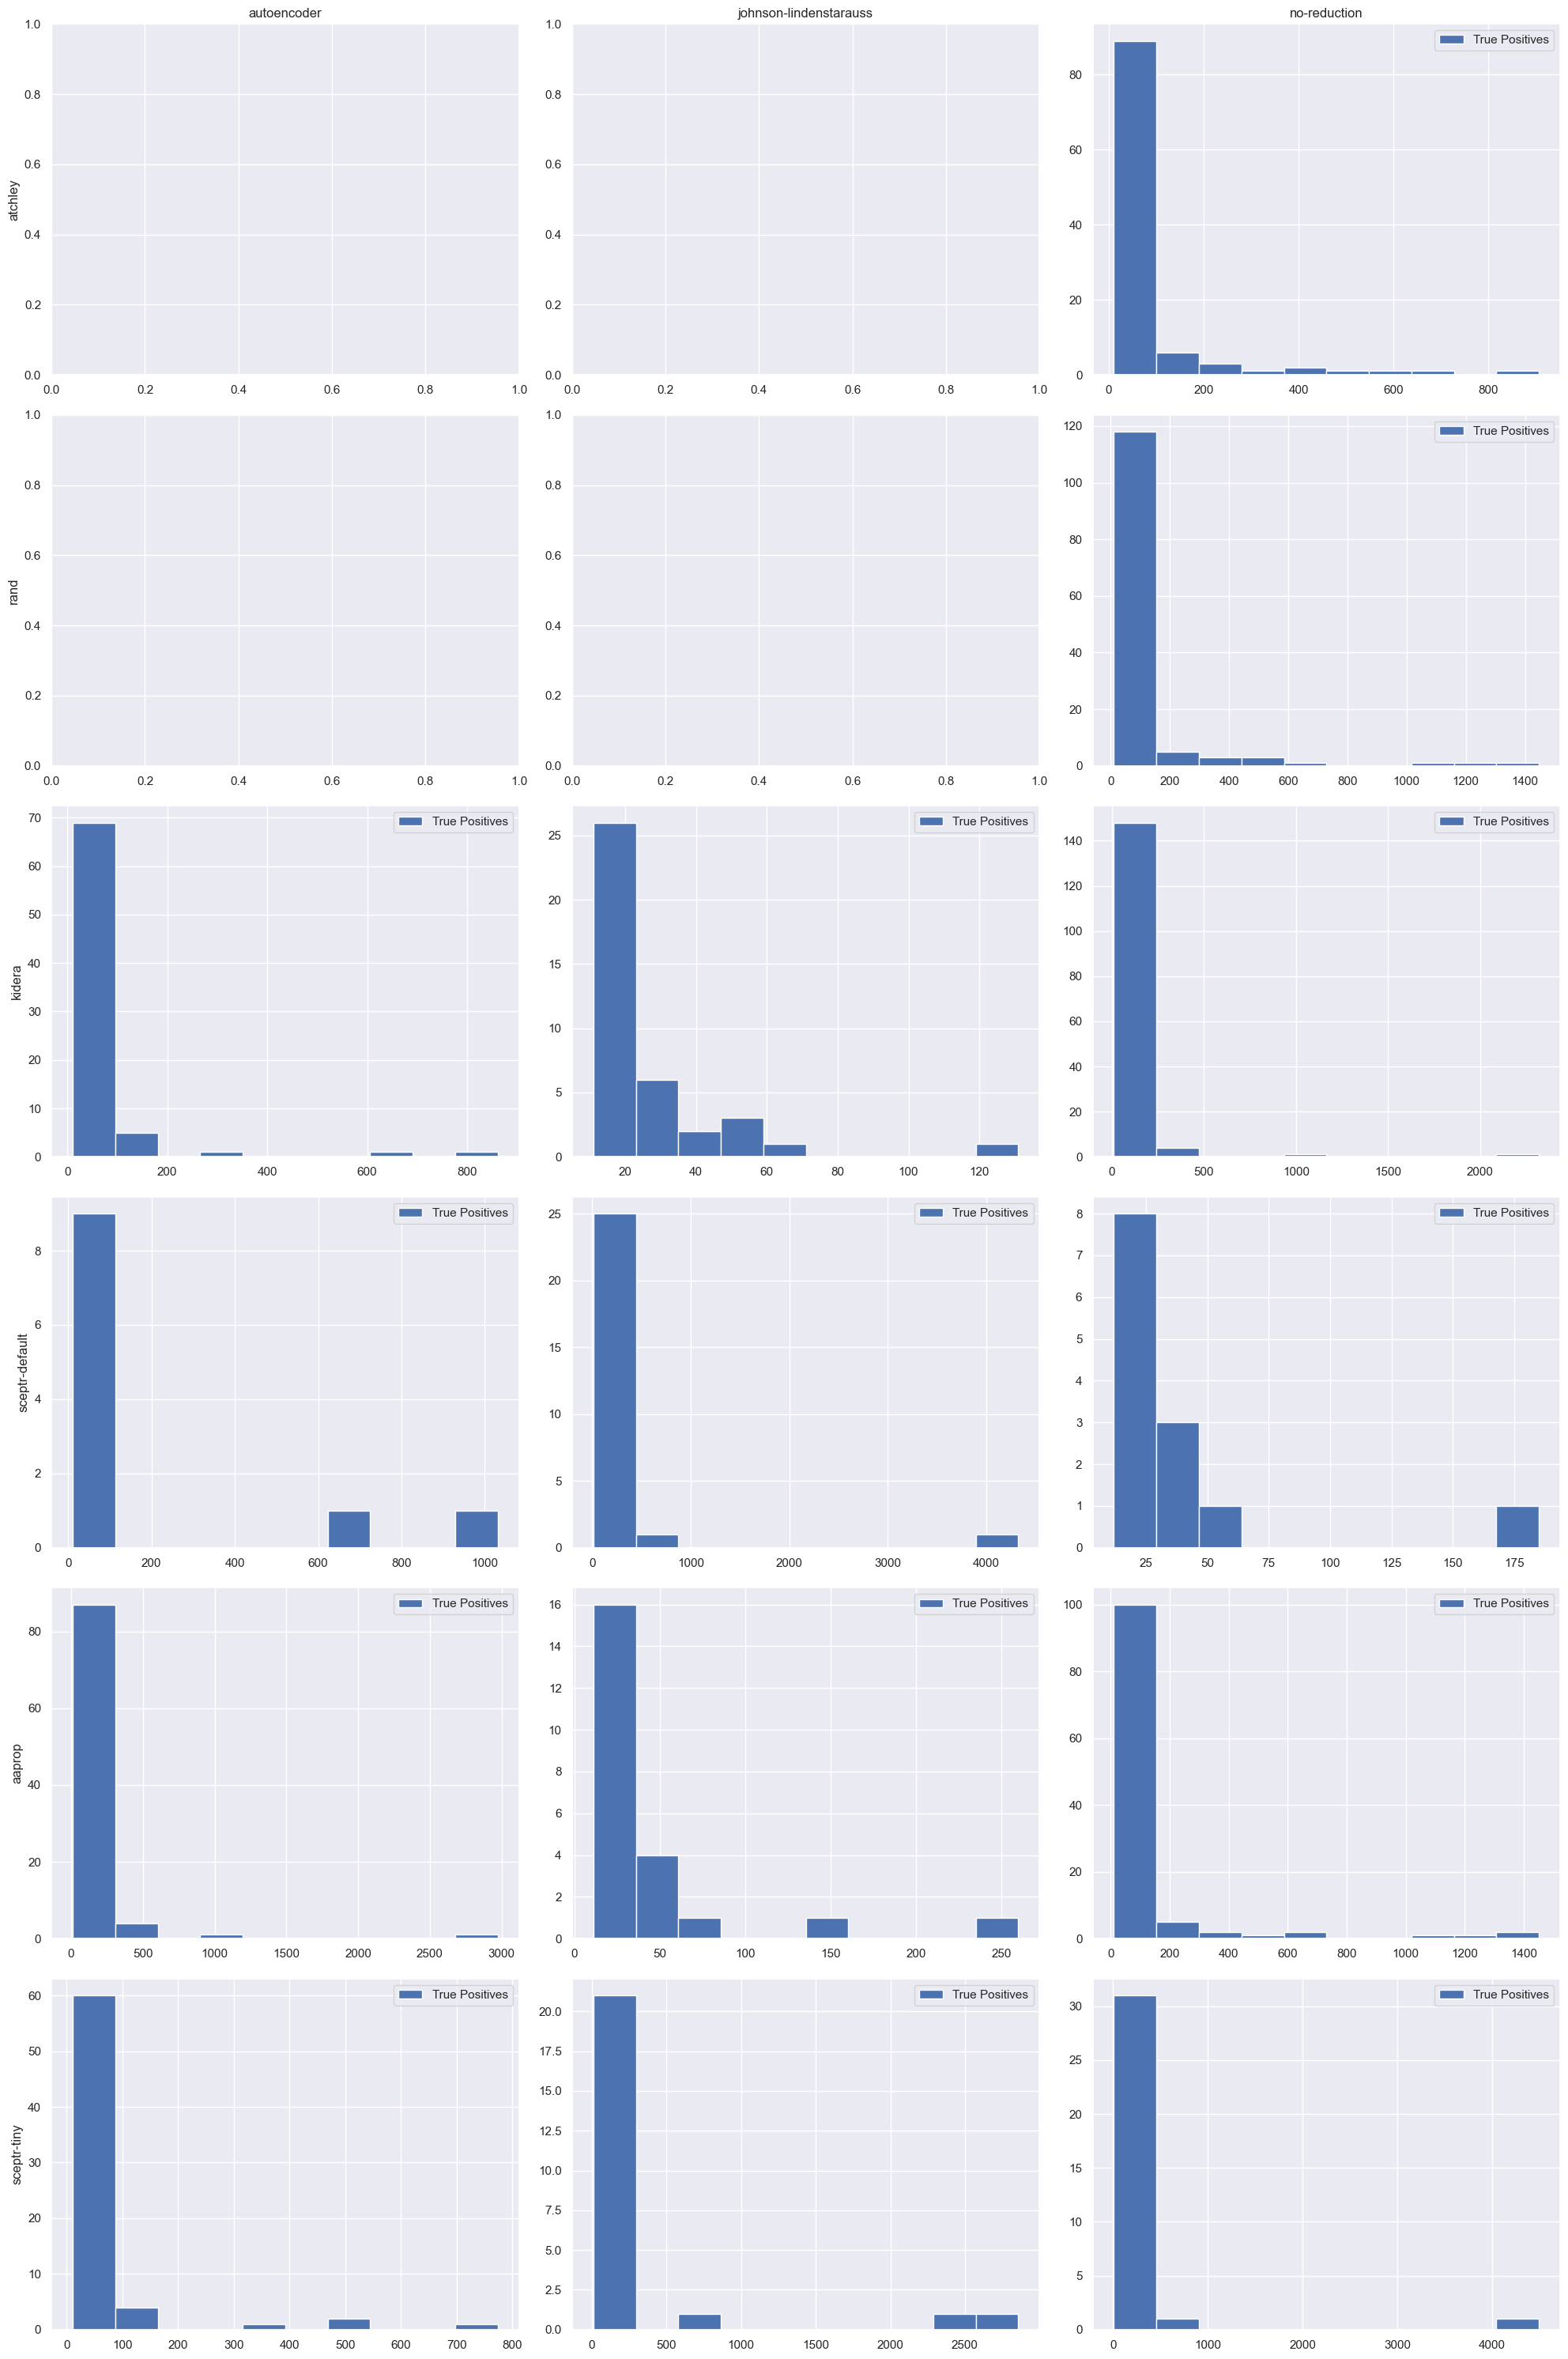

In [7]:
fig, axs = plt.subplots(ncols = 3, nrows = len(set_distinct_methods), figsize = (20, 30))

for (encoding_method, pos), freqs in dct_method_true_positives.items():
    axs[list(set_distinct_methods).index(encoding_method), pos].hist(
        [i for i in freqs if i > 10], 
        label = f"True Positives"
    )
    axs[list(set_distinct_methods).index(encoding_method), pos].legend()

for i in range(3):
    axs[0, i].set_title(pos_to_method_mapping[i])

for i in range(len(set_distinct_methods)):
    axs[i, 0].set_ylabel(list(set_distinct_methods)[i])

plt.tight_layout()

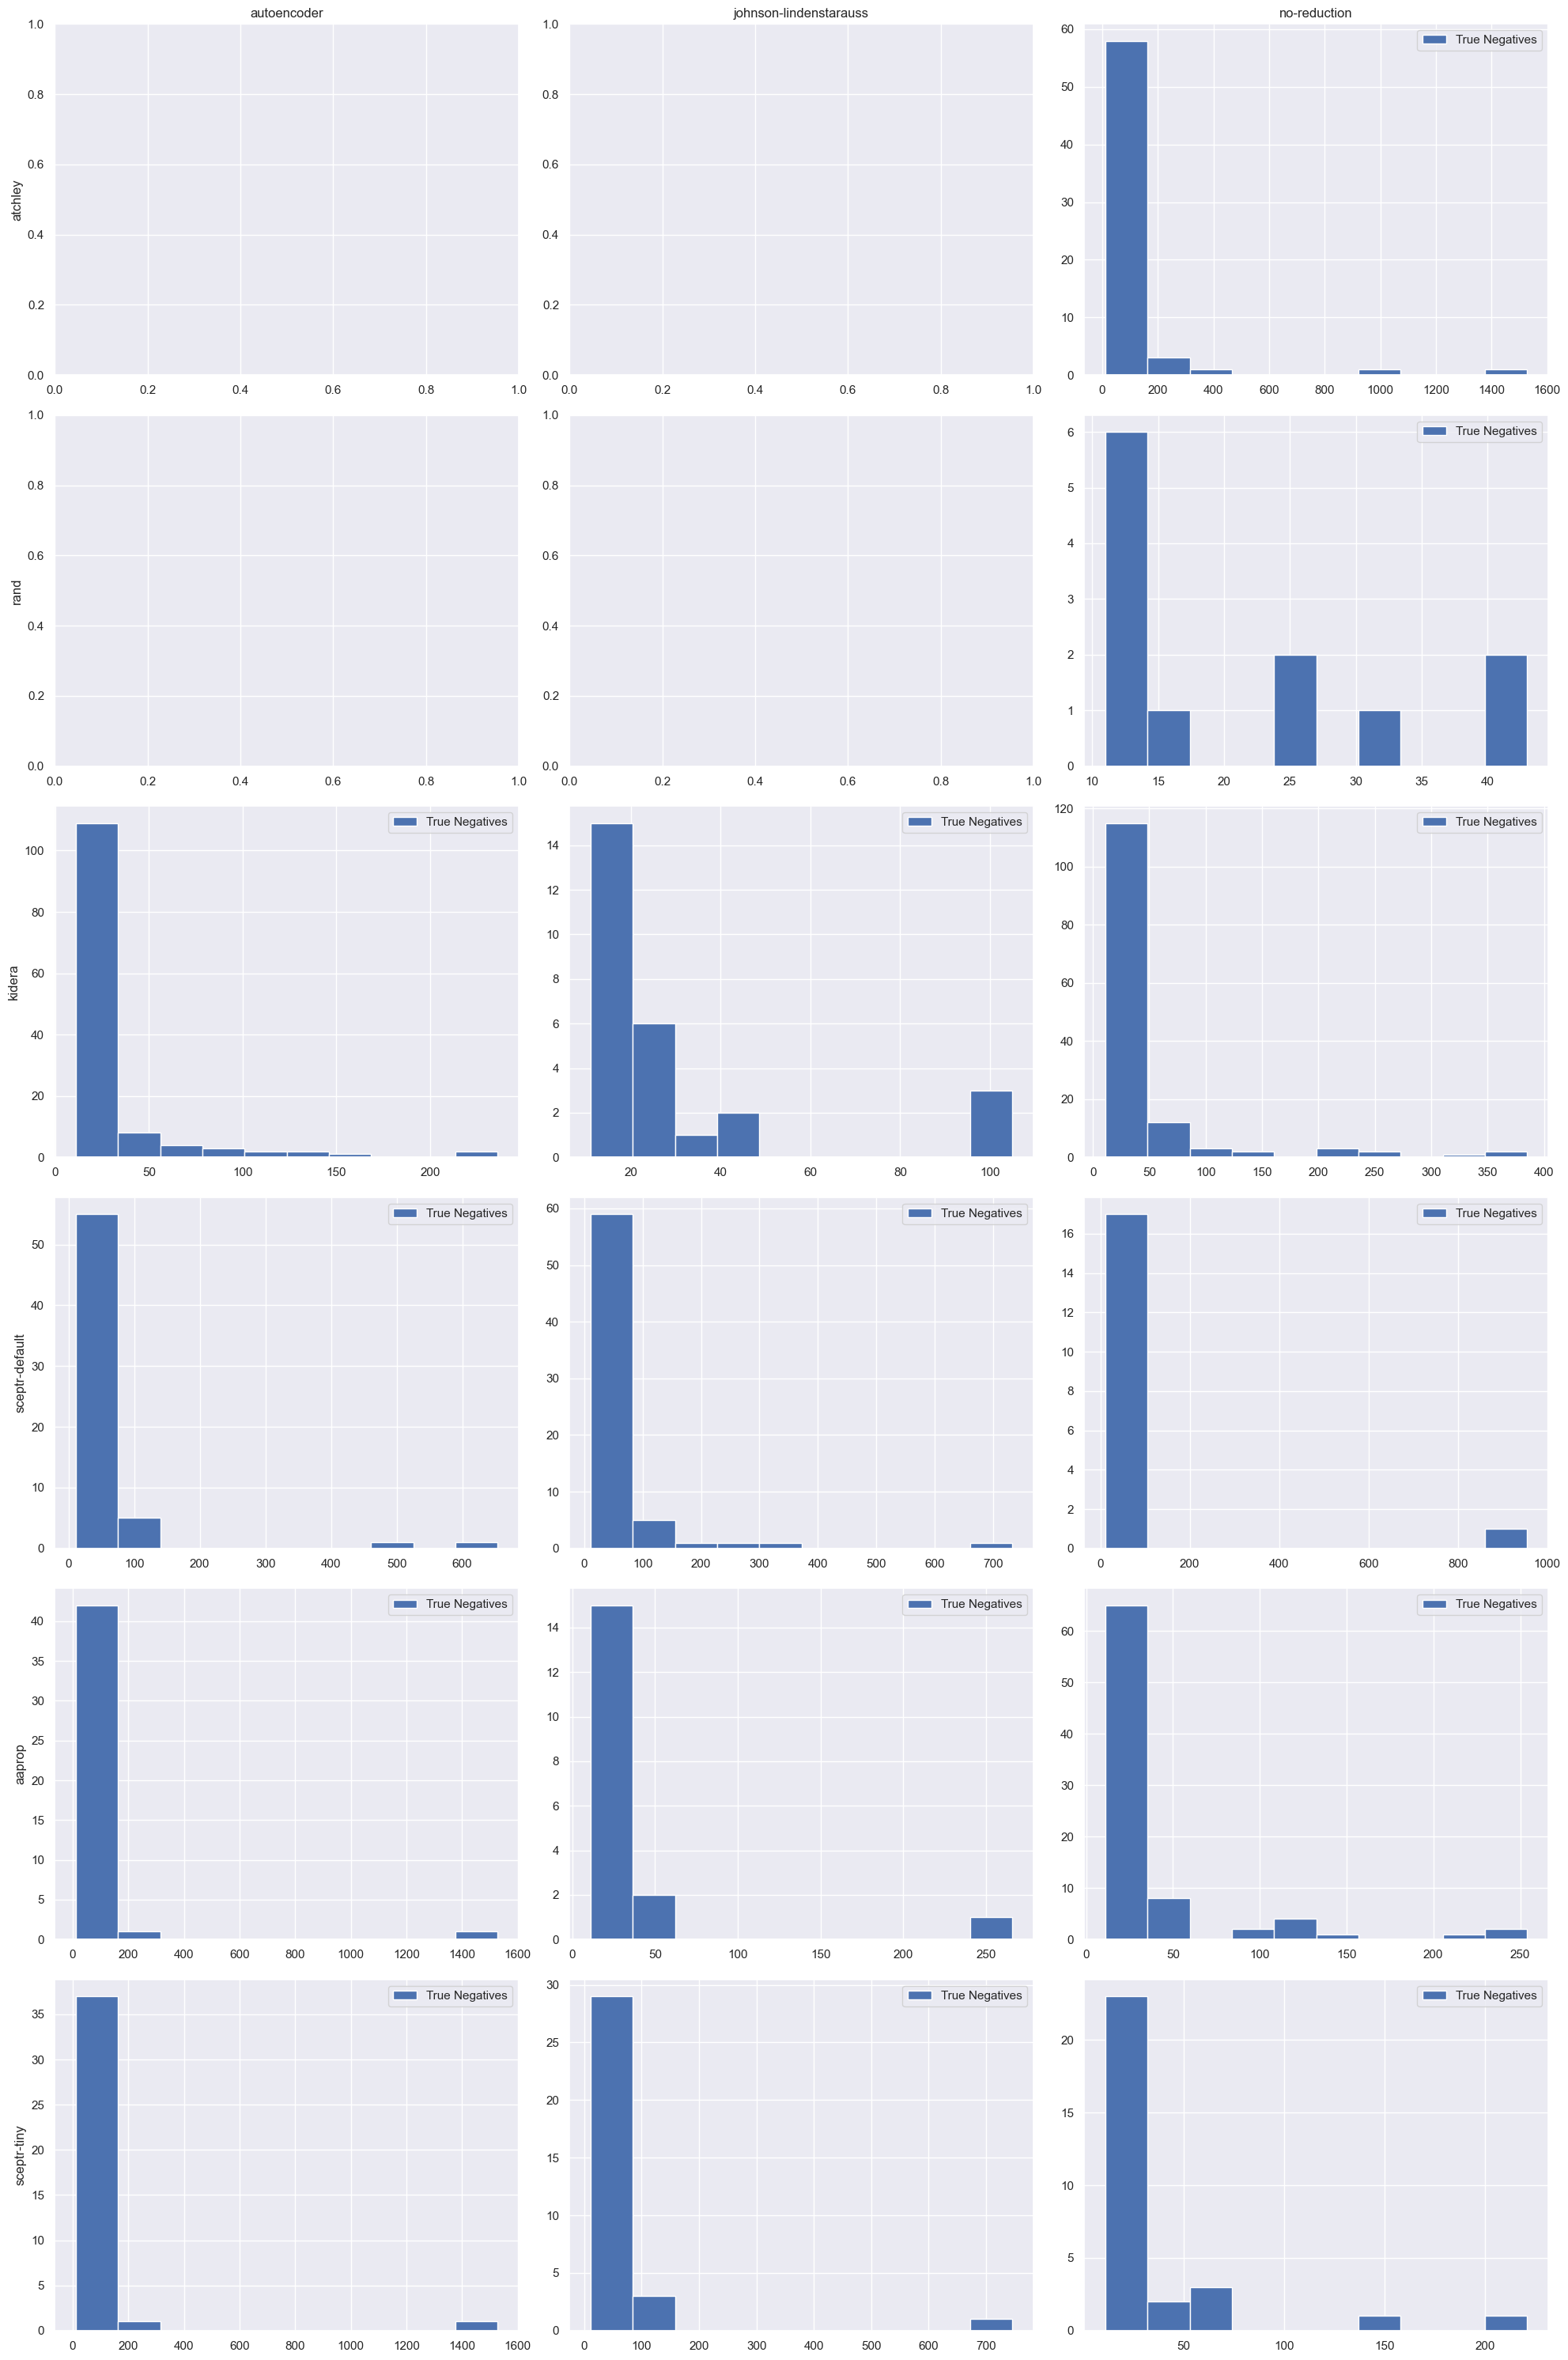

In [8]:
fig, axs = plt.subplots(ncols = 3, nrows = len(set_distinct_methods), figsize = (20, 30))

for (encoding_method, pos), freqs in dct_method_true_negatives.items():
    axs[list(set_distinct_methods).index(encoding_method), pos].hist(
        [i for i in freqs if i > 10], 
        label = f"True Negatives"
    )
    axs[list(set_distinct_methods).index(encoding_method), pos].legend()

for i in range(3):
    axs[0, i].set_title(pos_to_method_mapping[i])

for i in range(len(set_distinct_methods)):
    axs[i, 0].set_ylabel(list(set_distinct_methods)[i])

plt.tight_layout()